In [32]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader  
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import copy
import torch.nn.functional as F
import os
import h5py

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


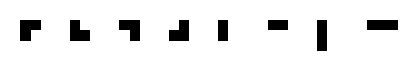

In [33]:
corner = np.zeros((2, 2))
corner[:1, :] = 1
corner[:, :1] = 1

bar1 = np.ones((2, 1))
bar2 = np.ones((1, 2))
bar3 = np.ones((3, 1), dtype=np.int64)
bar4 = np.ones((1, 3), dtype=np.int64)

objects = [
    corner.copy(),
    corner[::-1, :].copy(),
    corner[:, ::-1].copy(),
    corner[::-1, ::-1].copy(),
    bar1.copy(),
    bar2.copy(),
    bar3.copy(),
    bar4.copy() 
]

objects_edges = [
    [[0, 0], [2, 0], [2, 1], [1, 1], [1, 2], [0, 2], [0, 0]],
    [[0, 0], [2, 0], [2, 2], [1, 2], [1, 1], [0, 1], [0, 0]],
    [[0, 0], [1, 0], [1, 1], [2, 1], [2, 2], [0, 2], [0, 0]],
    [[1, 0], [2, 0], [2, 2], [0, 2], [0, 1], [1, 1], [1, 0]],
    
    [[0, 0], [2, 0], [2, 1], [0, 1], [0, 0]],
    [[0, 0], [1, 0], [1, 2], [0, 2], [0, 0]],
    [[0, 0], [3, 0], [3, 1], [0, 1], [0, 0]],
    [[0, 0], [1, 0], [1, 3], [0, 3], [0, 0]],
]

def draw_edge(ax, offset, shp_id):
    edge = np.array(objects_edges[shp_id])
    edge[:, 0] += offset[0]
    edge[:, 1] += offset[1]
    ax.plot(edge[:, 1], edge[:, 0], color='black', linewidth=2)

draw_fig = False
if draw_fig == True:
    for i in range(len(objects)):
        fig, axs = plt.subplots(1, 1, figsize=(15, 15))
        img = np.zeros((11, 11))
        img[1:1+objects[i].shape[0], 1:1+objects[i].shape[1]] = objects[i]
        sns.heatmap(img, square=True, xticklabels=False, yticklabels=False, cmap='Greys', cbar=False, ax=axs)
else:
    fig, axs = plt.subplots(1, len(objects), figsize=(5, 15))
    for i in range(len(objects)):
        img = np.zeros((4, 4))
        img[1:1+objects[i].shape[0], 1:1+objects[i].shape[1]] = objects[i]
        sns.heatmap(img, square=True, xticklabels=False, yticklabels=False, cmap='Greys', cbar=False, ax=axs[i])

In [ ]:
class CompositionEnv:
    def __init__(self, edge=10, objects=objects, min_object_num=5, max_object_num=5):
        self.edge = edge  # figure size
        self.dim = 2  # figure dim
        self.objects = objects

        # range of BB number
        self.min_object_num = min_object_num  
        self.max_object_num = max_object_num

        # calculate action number
        self.cal_action_to_observation_change()
        self.s_dim = self.edge * self.edge  # 图片大小, 即Qo的维度

    def cal_action_to_observation_change(self):
        self.obj_action_rng = {}  
        action_idx = 0
        action_to_observation_change = {}
        action_to_postion = {} 
        action_to_shape = {}
        for i in range(len(self.objects)):
            height = self.objects[i].shape[0]
            width = self.objects[i].shape[1]
            self.obj_action_rng[i] = [action_idx]
            for h in range(self.edge - height + 1):
                for w in range(self.edge - width + 1):
                    tmp_img = np.zeros((self.edge, self.edge), dtype=np.int64)
                    tmp_img[h:h+height, w:w+width] = self.objects[i]
                    action_to_observation_change[action_idx] = tmp_img
                    action_to_postion[action_idx] = [h, w]
                    action_to_shape[action_idx] = i
                    action_idx += 1
            self.obj_action_rng[i].append(action_idx)
        self.action_to_position = action_to_postion
        self.action_to_shape = action_to_shape
        self.action_to_observation_change = action_to_observation_change
        self.a_dim = action_idx

    def check_affordance(self, cur_state, action_idx):
        assert cur_state.shape == (self.edge, self.edge)
        obs_chg = self.action_to_observation_change[action_idx]
        if torch.all(cur_state[obs_chg == 1] == 1) == True:
            next_state = copy.deepcopy(cur_state)
            next_state[obs_chg == 1] = 0  
            return True, next_state
        else:
            return False, cur_state

    def gain_affordance_vector(self, cur_state):
        aff_vec = torch.zeros((1, self.a_dim), dtype=torch.float32, device=device)
        for i in range(self.a_dim):
            reachable, _ = self.check_affordance(cur_state, i)
            if reachable:
                aff_vec[0, i] = 1.0
        return aff_vec

    def check_arrive(self, cur_state):
        if np.all(cur_state == 0):
            return True
        else:
            return False

    def generate_one_sampling_trajectory(self, obj_seen_idx):
        cur_img = np.zeros((self.edge, self.edge), dtype=np.int64)
        obj_num = np.random.randint(self.min_object_num, self.max_object_num + 1)

        traj_info = {
            "action_index": [],
            "observation": []
        }

        traj_info["observation"].append(cur_img)
        for _ in range(obj_num):
            while True:
                if obj_seen_idx == -1:  
                    action_idx = np.random.randint(0, self.a_dim)
                else: 
                    action_idx = np.random.randint(0, self.obj_action_rng[obj_seen_idx][0])
                obj_chg = self.action_to_observation_change[action_idx]
                if np.all(cur_img[obj_chg == 1] == 0) == False:
                    continue
                else:
                    new_img = copy.deepcopy(cur_img)
                    new_img[obj_chg == 1] = 1
                    traj_info["observation"].append(new_img)
                    traj_info["action_index"].append(action_idx)
                    cur_img = new_img
                    break
        
        traj_info["action_index"].reverse()
        traj_info["observation"].reverse()

        return traj_info

    def check_adjacent_edge(self, obj_idx, cur_img, obj_chg):
        if obj_idx == 0:
            return False
        idx = np.where(obj_chg > 0)
        direc = [
            [0, 1],
            [0, -1],
            [1, 0],
            [-1, 0]
        ]
        coincidence_edge = 0
        for i in range(len(idx[0])):
            x = idx[0][i]
            y = idx[1][i]
            for d in direc:
                x_ = x + d[0]
                y_ = y + d[1]
                if x_ >= self.edge or y_ >= self.edge or x_ < 0 or y_ < 0:
                    continue
                if cur_img[x_, y_] > 0:
                    coincidence_edge += 1
                if coincidence_edge > 0: 
                    return False

        return True

    def generate_one_sampling_trajectory_dense(self, obj_seen_idx):
        cur_img = np.zeros((self.edge, self.edge), dtype=np.int64)
        obj_num = np.random.randint(self.min_object_num, self.max_object_num + 1)

        traj_info = {
            "action_index": [],
            "observation": []
        }

        traj_info["observation"].append(cur_img)
        for obj_idx in range(obj_num):
            while True:
                if obj_seen_idx == -1:  
                    action_idx = np.random.randint(0, self.a_dim)
                else:  
                    action_idx = np.random.randint(0, self.obj_action_rng[obj_seen_idx][0])
                obj_chg = self.action_to_observation_change[action_idx]
                if np.all(cur_img[obj_chg == 1] == 0) == False:
                    continue
                elif self.check_adjacent_edge(obj_idx, cur_img, obj_chg):
                    continue
                else:
                    new_img = copy.deepcopy(cur_img)
                    new_img[obj_chg == 1] = 1
                    traj_info["observation"].append(new_img)
                    traj_info["action_index"].append(action_idx)
                    cur_img = new_img
                    break
        
        traj_info = self.reorder_action_sequence(traj_info)
        
        traj_info["action_index"].reverse()
        traj_info["observation"].reverse()
        traj_info["element_index"].reverse()

        return traj_info
    
    def reorder_action_sequence(self, traj_info):
        pos = []
        for action in traj_info["action_index"]:
            pos.append(self.action_to_position[action])
        pos = np.array(pos)
        sorted_index = np.lexsort((-pos[:, 0], -pos[:, 1])) 
        sorted_data = pos[sorted_index]

        cur_img = copy.deepcopy(traj_info["observation"][0])
        new_traj_info = {}
        new_traj_info["observation"] = []
        new_traj_info["action_index"] = []
        new_traj_info["element_index"] = []
        new_traj_info["observation"].append(cur_img)
        for obj_idx in range(len(traj_info["action_index"])):
            action_idx = traj_info["action_index"][sorted_index[obj_idx]]  # 排序后的action_index
            obj_chg = self.action_to_observation_change[action_idx]
            new_img = copy.deepcopy(cur_img)
            new_img[obj_chg == 1] = 1
            new_traj_info["observation"].append(new_img)
            new_traj_info["action_index"].append(action_idx)
            new_traj_info["element_index"].append(self.action_to_shape[action_idx])
            cur_img = new_img
        
        return new_traj_info

    def generate_dataset(self, data_num, obj_seen_idx=-1, dense=False):
        dataset = []
        for i in range(data_num):
            if i % 1000 == 0:
                print(i, "/", data_num)
            if dense == True:
                dataset.append(self.generate_one_sampling_trajectory_dense(obj_seen_idx))
            else:
                dataset.append(self.generate_one_sampling_trajectory(obj_seen_idx))
        return dataset

class CompositionEnvDataset(Dataset):
    def __init__(self, db_dir="/home/linhui/linhui21/cml/dataset/tiling_order_10x10_5obj.h5", train=True, train_data_num=38000):
        with h5py.File(db_dir, 'r') as f:
            if train:
                # (data_num, traj_len, data_size)
                pre_obs = f["tiling"]["pre_obs"][:train_data_num]
                post_obs = f["tiling"]["post_obs"][:train_data_num]
                action = f["tiling"]["action"][:train_data_num]
            else:
                # (data_num, traj_len, data_size)
                pre_obs = f["tiling"]["pre_obs"][train_data_num:]
                post_obs = f["tiling"]["post_obs"][train_data_num:]
                action = f["tiling"]["action"][train_data_num:]
            pre_obs = torch.tensor(pre_obs, dtype=torch.float32, device=device)
            post_obs = torch.tensor(post_obs, dtype=torch.float32, device=device)
            action = torch.tensor(action, dtype=torch.int32, device=device)

            self.pre_obs = pre_obs
            self.post_obs = post_obs
            self.action = action

    def __len__(self):
        return self.pre_obs.shape[0]

    def __getitem__(self, idx):
        return (self.pre_obs[idx, :, :], self.action[idx, :], self.post_obs[idx, :, :])

In [35]:
composition_env = CompositionEnv()
composition_env_dataset = CompositionEnvDataset(db_dir="./dataset/tiling_10x10_5obj.h5", train=True, train_data_num=18000)
dataloader = DataLoader(composition_env_dataset, batch_size=4096, shuffle=True)

a_dim: 664
action_idx [554, 399, 486, 228, 136]


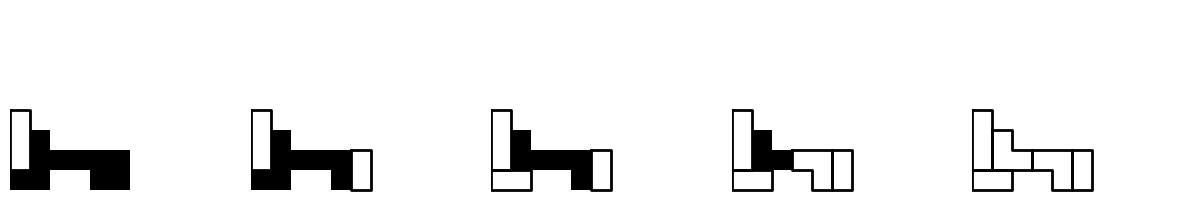

In [36]:
draw_idx = 2
print("a_dim:", composition_env.a_dim)
print("action_idx", composition_env_dataset[draw_idx][1].to(torch.int).cpu().numpy().tolist())
img_num = composition_env_dataset[draw_idx][0].shape[0]

fig, axs = plt.subplots(1, img_num , figsize=(15, 15))
tmp_actions = []
for i in range(img_num):
    img = composition_env_dataset[draw_idx][0][i].cpu().numpy().reshape((composition_env.edge, composition_env.edge))
    action_idx = int(composition_env_dataset[draw_idx][1][i].cpu().item())
    tmp_actions.append(action_idx)
    for action_idx in tmp_actions:
        draw_edge(axs[i], composition_env.action_to_position[action_idx], composition_env.action_to_shape[action_idx])
    img -= composition_env.action_to_observation_change[action_idx] * 1
    sns.heatmap(img, square=True, xticklabels=False, yticklabels=False, cmap='Greys', cbar=False, vmin=0., vmax=1., ax=axs[i])
plt.show()

In [37]:
class CompositionCML(nn.Module):
    def __init__(self, o_size, a_size, s_dim, edge):
        super(CompositionCML, self).__init__()
        
        self.o_size = o_size  # image size
        self.a_size = a_size  # action space size
        self.s_dim  = s_dim  # state space size
        self.hidden_size = o_size
        self.edge = edge
        
        self.Q = nn.Parameter(0.001 * torch.ones(self.o_size, self.hidden_size, device=device))
        self.V = nn.Parameter(0.001 * torch.randn(self.a_size, self.hidden_size, device=device))

        self.W = nn.Parameter(0.01 * torch.randn(a_size, self.hidden_size, device=device))

        
        self.q_conv_ = nn.Conv2d(1, 1, kernel_size=(3, 3), stride=1, padding=0, bias=False, device=device)
        self.q_conv_.weight.data = torch.tensor([[[[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]]]], device=device)
    
    def q_conv(self, x):
        x_padded = F.pad(x, pad=(1, 1, 1, 1), mode='constant', value=1)
        y = self.q_conv_(x_padded)
        return y

    def Q_encoder(self, x):
        y = x.reshape((-1, 1, self.edge, self.edge))
        s = self.q_conv(1 - y)
        s = s.reshape((-1, self.edge * self.edge))
        s = s * x  
        return s
        
def train_network(model: CompositionCML, env: CompositionEnv, o_pre, action, o_next):
    batch_size = o_pre.shape[0]

    assert o_pre.shape == (batch_size, env.edge * env.edge)
    assert o_next.shape == (batch_size, env.edge * env.edge)
    assert action.shape == (batch_size, )

    s_a = model.V[action, :]  # (b_s, n_s)
    predict_error = o_next - (o_pre + s_a)

    loss_q = nn.MSELoss()(predict_error, torch.zeros_like(predict_error))

    model.V[action, :] += 0.01 * predict_error
    model.W[action, :] = o_next - o_pre

    return loss_q

def train_model(model: CompositionCML, env: CompositionEnv, dataloader, epochs):
    with torch.no_grad():
        for epoch in tqdm(range(epochs), desc="Epochs"):
            l_q_ = 0
            idx = 0

            for trajectory in dataloader:
                for step in range(trajectory[0].shape[1]):
                    o_pre, action, o_next = trajectory[0][:, step, :], \
                                            trajectory[1][:, step], \
                                            trajectory[2][:, step, :]
                    
                    loss_q = train_network(model, env, o_pre, action, o_next)

                    l_q_ += loss_q * o_pre.shape[0]
                    idx += o_pre.shape[0]
            l_q_step = l_q_.cpu().item() / idx
            
            print(f"epoch:{epoch}, q loss: {l_q_step}")


epochs = 100

load_trained_model = True
if load_trained_model:
    model = CompositionCML(o_size=composition_env.edge**2, a_size=composition_env.a_dim, s_dim=composition_env.edge**2, edge=composition_env.edge)
    model.load_state_dict(torch.load("./tmp_data/fig4_tiling.pth"))
    model = model.to(device)
else:
    model = CompositionCML(o_size=composition_env.edge**2, a_size=composition_env.a_dim, s_dim=composition_env.edge**2, edge=composition_env.edge)
    model = model.to(device)
    train_model(model, composition_env, dataloader, epochs)
    torch.save(model.state_dict(), "./tmp_data/fig4_tiling.pth")

In [38]:
INF = 100000
def move_one_step_trajectory(model: CompositionCML, env: CompositionEnv, loc_, goal, traj_len, traj_num, noise_param, pure_rand=False):
    batch_size = 1

    traj_rec = []
    traj_reachable_rec = []
    action_rec = []
    for traj_id in range(traj_num):
        loc = copy.deepcopy(loc_)
        traj = [loc]
        act = []
        traj_reachable = False
        for step_id in range(traj_len):
            affordance_vector = env.gain_affordance_vector(loc.reshape((env.edge, env.edge)))

            assert affordance_vector.shape == (1, model.a_size)

            if torch.all(affordance_vector == 0) == True:
                traj_reachable = False
                break

            s_pre = model.Q_encoder(loc.reshape((1, -1)))
            utility = model.W @ (0 - s_pre.T)
            utility[affordance_vector.reshape((-1,)).int() == 0] = -INF

            assert(utility.shape == (model.a_size, batch_size))

            if pure_rand:
                utility = torch.randn_like(utility)
            else:
                if traj_num > 1:
                    utility += torch.randn_like(utility) * noise_param["sigma"] * torch.max(utility)

            utility[affordance_vector.reshape((-1,)).int() == 0] = -INF

            if torch.max(utility) != -INF:
                action_idx = torch.argmax(utility).item()
            else:
                indices = torch.where(affordance_vector == 1)[1]
                action_idx = indices[torch.randint(len(indices), (1,))].squeeze().item()

            act.append(action_idx)

            reachable, next_state = env.check_affordance(loc.reshape((env.edge, env.edge)), action_idx)
            assert reachable == True

            loc = next_state.reshape((1, -1))
            traj.append(loc.clone())

            if torch.all(next_state == 0) == True:
                traj_reachable = True
                break

        traj_rec.append(traj)
        traj_reachable_rec.append(traj_reachable)
        action_rec.append(act)

    return traj_rec, traj_reachable_rec, action_rec

def plan_trajectory(model, env, start, goal, traj_len, traj_num, noise_param, pure_rand=False):
    start = start.reshape((1, -1))
    goal = goal.reshape((1, -1))

    loc = copy.deepcopy(start)

    traj_rec, traj_reachable_rec, action_rec = move_one_step_trajectory(model, env, loc, goal, traj_len, traj_num, noise_param, pure_rand=pure_rand)

    return traj_rec, traj_reachable_rec, action_rec

def test_model_trajectory(model, env, dataloader, traj_len=10, traj_num=20, draw=True, pure_rand=False, test_single=False, test_dataset_idxs=None):
    with torch.no_grad():
        traj_reachable_recs = []
        spk_recs = []
        idx = 0
        for trajectory in tqdm(dataloader, desc="Epoch:"):
            if test_dataset_idxs is not None:
                if idx not in test_dataset_idxs:
                    idx += 1
                    continue
                else:
                    idx += 1
            
            o_pre = trajectory[0].squeeze(dim=0)  # (traj_len, 784)
            o_next = trajectory[2].squeeze(dim=0)  # (traj_len, 784)
    
            traj_rec, traj_reachable_rec, action_rec = plan_trajectory(model, env, o_pre[0, :], o_next[-1, :], traj_len=traj_len, traj_num=traj_num, noise_param={"sigma":0.1}, pure_rand=pure_rand)
            traj_reachable_recs.append(traj_reachable_rec)

            if draw:
                plt.figure(figsize=(2, 2))
                ax = plt.gca()
                sns.heatmap(o_pre[0, :].reshape(env.edge, env.edge).cpu().numpy(), square=True, xticklabels=False, yticklabels=False, cmap='Greys', vmin=0., vmax=1., cbar=False, ax=ax)
                plt.show()

                for traj_id in range(len(traj_rec)):
                    o_record = traj_rec[traj_id]
                    a_rec = action_rec[traj_id]
                    fig, axs = plt.subplots(1, len(o_record) - 1, figsize=(15, 2))
                    tmp_actions = []
                    for i in range(len(o_record) - 1):
                        if i >= len(o_record):
                            img = torch.zeros((env.edge, env.edge))
                        else:
                            img = o_record[i].reshape((env.edge, env.edge)).detach().cpu().numpy()
                        if i < len(o_record) - 1:
                            action_idx = a_rec[i]
                            # img += composition_env.action_to_observation_change[action_idx]

                        tmp_actions.append(action_idx)
                        for action_idx in tmp_actions:
                            draw_edge(axs[i], composition_env.action_to_position[action_idx], composition_env.action_to_shape[action_idx])
                        img -= composition_env.action_to_observation_change[action_idx]

                        sns.heatmap(img, square=True, xticklabels=False, yticklabels=False, cmap='Greys', vmin=0., vmax=1., cbar=False, ax=axs[i])
                        axs[i].set_xlim([-0.1, 10.1])
                        axs[i].set_ylim([10.1, -0.1])
                    plt.show()

            if test_single:
                break
    return traj_reachable_recs, spk_recs

Epoch::   0%|          | 0/2000 [00:00<?, ?it/s]

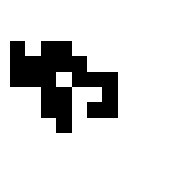

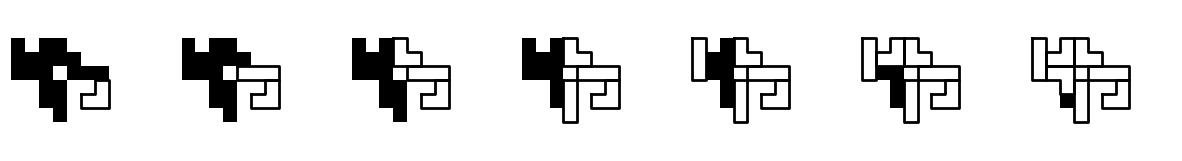

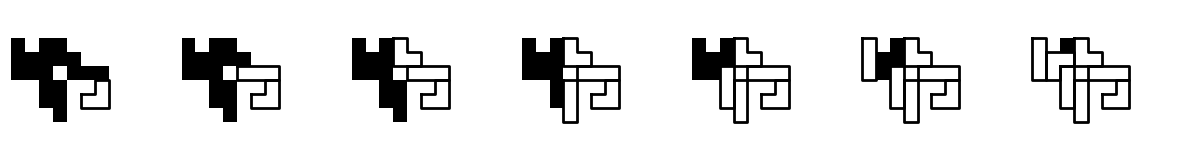

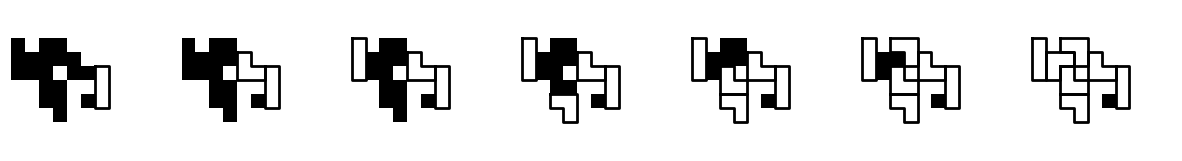

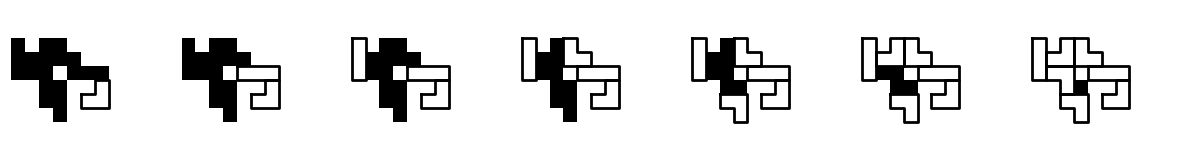

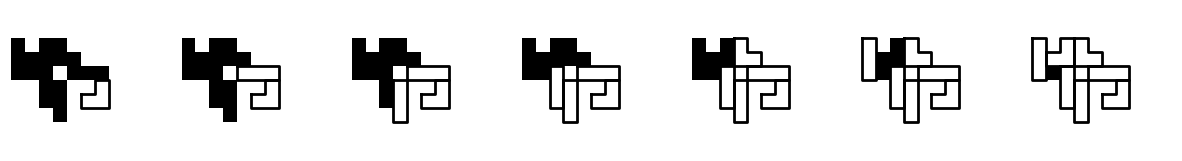

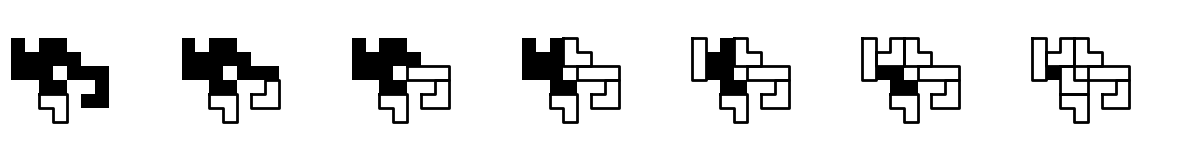

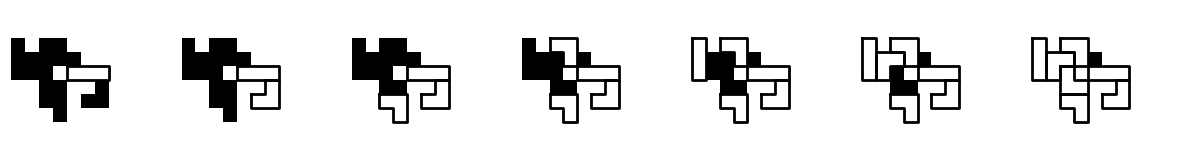

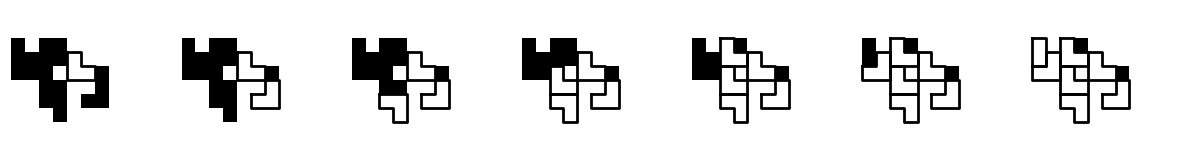

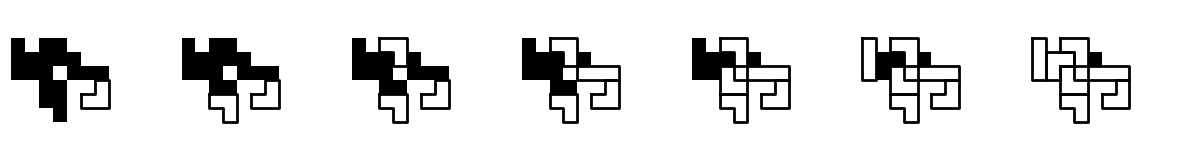

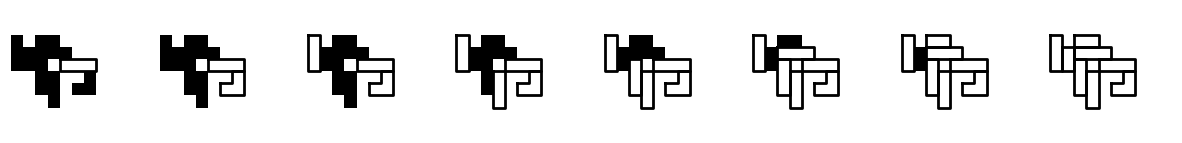

In [39]:
composition_env_dataset_test = CompositionEnvDataset(train=False, train_data_num=18000, db_dir="./dataset/tiling_order_10x10_8obj.h5")
test_dataloader = DataLoader(composition_env_dataset_test, batch_size=1, shuffle=False)
loss_record, spk_recs = test_model_trajectory(model, composition_env, test_dataloader, traj_len=8, traj_num=10, test_single=True, test_dataset_idxs=[2])  

## cognitive map analysis

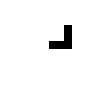

In [40]:
composition_env_dataset_test = CompositionEnvDataset(train=False, train_data_num=18000)
data_idx = 5
step = 3
loc = composition_env_dataset_test[data_idx][0][step]

plt.figure(figsize=(1, 1))
ax = plt.gca()
sns.heatmap(loc.cpu().reshape(composition_env.edge, composition_env.edge), square=True, xticklabels=False, yticklabels=False, cmap='Greys', vmin=0., vmax=1., cbar=False, ax=ax)

affordance_vector_0 = composition_env.gain_affordance_vector(loc.reshape((composition_env.edge, composition_env.edge)))

possible_silhouette = []
edge = []

def dfs(father_idx, cur_loc, affordance_vec, step):
    cur_loc_list = cur_loc.clone().cpu().numpy().tolist()
    if step >= 5 - step:
        return
    if cur_loc_list in possible_silhouette:
        cur_idx = possible_silhouette.index(cur_loc_list)
        edge.append([father_idx, cur_idx])
        return
    cur_idx = len(possible_silhouette)
    if father_idx != -1:
        edge.append([father_idx, cur_idx])
    possible_silhouette.append(cur_loc_list)
    affordance_vec_idx = torch.where(affordance_vec > 0.5)[1]
    for i in range(len(affordance_vec_idx)):
        action_idx = int(affordance_vec_idx[i])
        reachable, next_state = composition_env.check_affordance(cur_loc.reshape((composition_env.edge, composition_env.edge)), action_idx)
        assert reachable == True
        affordance_vec_new = torch.zeros_like(affordance_vec)
        pos_action_idx = torch.where(affordance_vec > 0.5)[1]
        for j in range(len(pos_action_idx)):
            action_idx = int(pos_action_idx[j])
            reachable, _ = composition_env.check_affordance(next_state.reshape((composition_env.edge, composition_env.edge)), action_idx)
            if reachable == True:
                affordance_vec_new[:, action_idx] = 1
        dfs(cur_idx, next_state.reshape((1, -1)), affordance_vec_new, step + 1)

dfs(-1, loc, affordance_vector_0, 0)

In [41]:
high_dim_state = []
pixel_num = []
for i in range(len(possible_silhouette)):
    pixel_num.append(np.sum(possible_silhouette[i]))
    o_pre = torch.tensor(possible_silhouette[i]).to(device).reshape((1, -1))
    high_dim_state.append(model.Q_encoder(o_pre).squeeze().cpu().detach().numpy())
    # high_dim_state.append((model(o_pre)).squeeze().cpu().detach().numpy())

node_num = len(high_dim_state)
adj_matrix = np.zeros((node_num, node_num), dtype=np.int32)

for i in range(len(possible_silhouette)):
    if np.all(np.array(possible_silhouette[i]) == 0):
        target_idx = i
        break

for e in edge:
    adj_matrix[e[0], e[1]] = 1

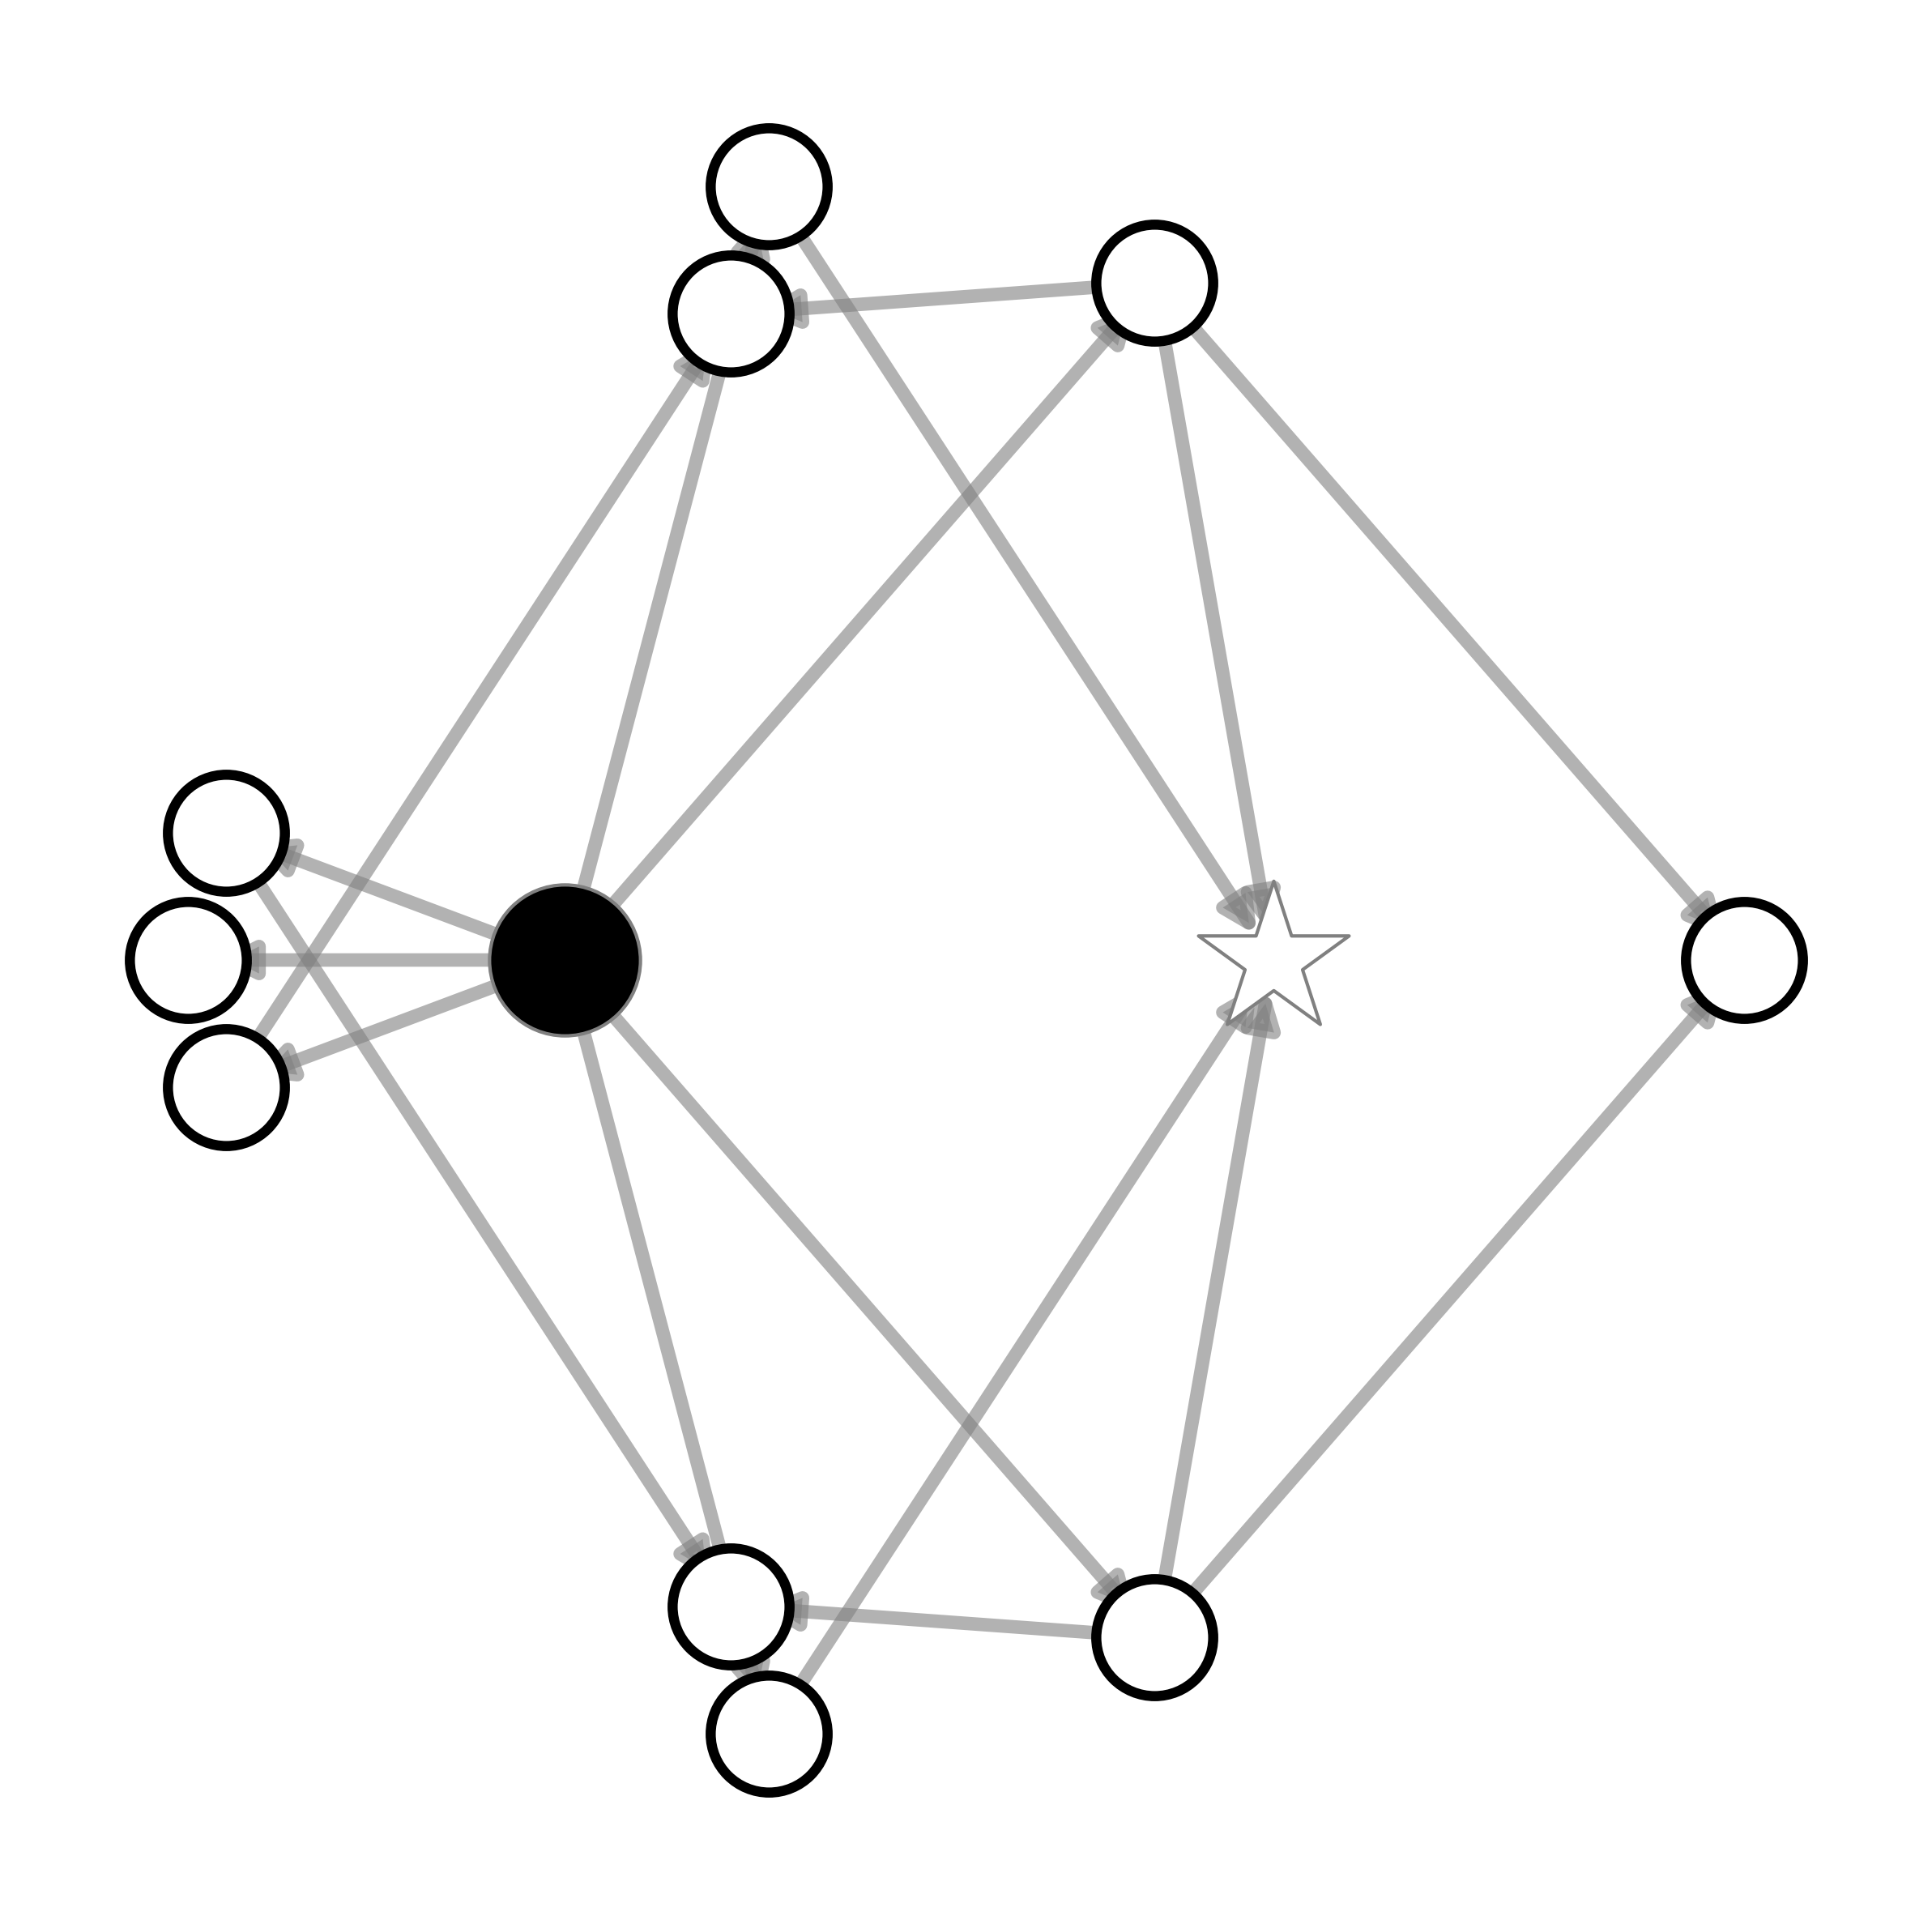

In [43]:
from sklearn.decomposition import PCA
high_dim_state = np.array(high_dim_state)

def run_t_sne(node, adjacency, start=None, goal=None, node_color=None, USE_PCA=True):
    node_color = copy.deepcopy(node_color)
    data = node.T
    N_nodes = node.shape[0]
    
    if USE_PCA:
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(high_dim_state)
    else:
        tsne = TSNE(2, perplexity=7.3, init='pca', early_exaggeration=7.5, learning_rate=100)
        data_2d = tsne.fit_transform(high_dim_state)

    if start == goal == None:
        G = nx.from_numpy_array(adjacency, create_using=nx.Graph())
    pos = {}
    for i in range(N_nodes):
        pos[i] = data_2d[i]
    if start!= None and goal!=None:
        fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
        G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph())
    else:
        fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    nodelist = list(range(0,N_nodes))
    if goal != None:
        nodelist.remove(goal)
        node_color.pop(goal)
        nx.draw_networkx_nodes(G, pos, nodelist = [goal], node_color='white', node_shape='*', edgecolors='gray', node_size=2200, linewidths=1)
    if start != None:
        nodelist.remove(start)
        node_color.pop(start)
        nx.draw_networkx_nodes(G, pos, nodelist = [start], node_color='black', edgecolors='gray', node_size=2000, linewidths=1)
    
    node_size = 1200
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color='white', edgecolors='black', node_size=node_size, linewidths=3)

    nx.draw_networkx_edges(G, pos, edge_color='grey', width=4, arrowsize=20, alpha=0.6)
    ax = plt.gca()
    ax.axis('off')

run_t_sne(high_dim_state, adj_matrix, 0, target_idx, pixel_num)